## Importing libraries

In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.optimizers import Adam
import scipy.io
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras import layers, models, optimizers
from PIL import Image, ImageOps
import random

## Setting seed

In [2]:
def set_seed(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_seed(42)

## Reading data

In [6]:
def load_dataset(image_dir, gt_dir, target_size=(224, 224)):
    X = []
    y = []
    c = 0
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    image_files.sort()  # opcjonalnie

    if not image_files:
        raise ValueError("Brak plików .jpg w podanym katalogu!")

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        mat_path = os.path.join(gt_dir, 'GT_' + img_file.replace('.jpg', '.mat'))

        # Wczytaj i przeskaluj obraz do dokładnego rozmiaru target_size (bez paddingu)
        img = Image.open(img_path).convert('RGB')
        img_resized = img.resize(target_size, Image.LANCZOS)

        # Konwersja do numpy + preprocess_input (dla MobileNet)
        img_array = np.array(img_resized, dtype=np.float32)
        img_array = preprocess_input(img_array)

        # Wczytaj ground truth (liczba osób)
        mat = scipy.io.loadmat(mat_path)
        count = len(mat['image_info'][0][0][0][0][0])

        X.append(img_array)
        y.append(count)
        # if c == 1:
        #     plt.imshow(img_resized)
        #     print(img_path)
        #     print(count)
        #     break
        # c += 1

    return np.array(X), np.array(y)

## Getting the training set and the test set

In [7]:
X_train, y_train = load_dataset('../ShanghaiTech/part_B/train_data/images/', '../ShanghaiTech/part_B/train_data/ground-truth/')

In [8]:
X_test, y_test = load_dataset('../ShanghaiTech/part_B/test_data/images/', '../ShanghaiTech/part_B/test_data/ground-truth/')

## Building the model

In [9]:
# Load pre-trained model without top classifier layers
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# base_model.trainable = True
# for layer in base_model.layers[:-30]: # Unfreeze last 30 layers
#     layer.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])

model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])

## Data augmentation and training the model

In [10]:
# Function to augment
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

def augment(x, y):
    return data_augmentation(x), y

training_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
training_set = training_set.map(augment)  # augment
training_set = training_set.batch(32).prefetch(tf.data.AUTOTUNE)
history = model.fit(training_set, batch_size=32,
    epochs=20, shuffle=True, validation_data=(X_test, y_test)
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 163s 9s/step - loss: 23141.9668 - mae: 119.2219 - val_loss: 14351.4023 - val_mae: 79.0201
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 104s 8s/step - loss: 14218.9561 - mae: 82.7655 - val_loss: 8808.6963 - val_mae: 64.3093
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 104s 8s/step - loss: 9300.9258 - mae: 69.6772 - val_loss: 7885.1470 - val_mae: 68.4492
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 105s 8s/step - loss: 8230.9189 - mae: 68.8625 - val_loss: 7567.6875 - val_mae: 67.0016
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 104s 8s/step - loss: 8178.6963 - mae: 68.9119 - val_loss: 7154.4321 - val_mae: 62.3102
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 106s 8s/step - loss: 7418.9634 - mae: 64.5248 - val_loss: 6855.7627 - val_mae: 59.4108
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 104s 8s/step - loss: 7151.7681 - mae: 63.0258 - val_loss: 6569.1030 - val_mae: 56.9188
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 105s 8s/step - loss: 7096.8188 - mae: 60.9179 - val_loss: 6277.5845 - val_mae: 55.1

## Training curves visualisation

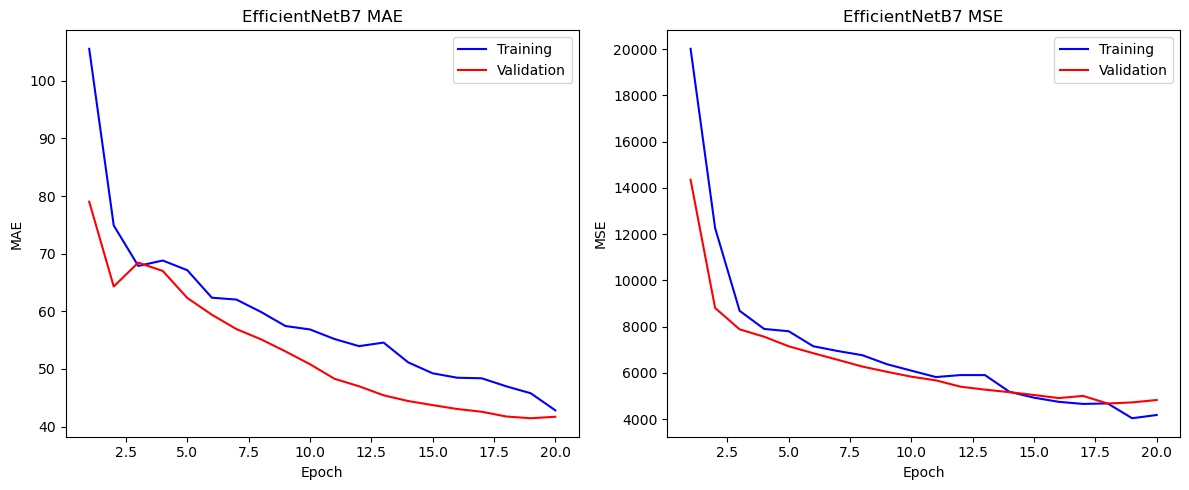

In [11]:
history_dict = history.history

# Getting the metrics
mae = history_dict['mae']
val_mae = history_dict.get('val_mae')
loss = history_dict['loss']
val_loss = history_dict.get('val_loss')

epochs = range(1, len(mae) + 1)

# MAE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, mae, 'b-', label='Training')
if val_mae:
    plt.plot(epochs, val_mae, 'r-', label='Validation')
plt.title('EfficientNetB7 MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Loss (MSE)
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training')
if val_loss:
    plt.plot(epochs, val_loss, 'r-', label='Validation')
plt.title('EfficientNetB7 MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

## Making predictions

In [12]:
y_pred = np.round(model.predict(X_test))

10/10 ━━━━━━━━━━━━━━━━━━━━ 66s 6s/step  


In [13]:
y_pred.reshape(len(y_pred), 1)
y_test.reshape(len(y_test), 1)
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1))

[[ 16.  23.]
 [130. 181.]
 [162. 157.]
 [ 61.  37.]
 [105.  70.]
 [ 51.  57.]
 [ 34.  44.]
 [170. 227.]
 [155. 165.]
 [192. 476.]
 [126. 139.]
 [178. 316.]
 [122. 164.]
 [146. 110.]
 [ 36.  20.]
 [127. 131.]
 [ 60.  48.]
 [154. 183.]
 [146. 101.]
 [173. 204.]
 [ 89.  40.]
 [113. 143.]
 [119. 146.]
 [218. 513.]
 [ 71.  70.]
 [ 78. 175.]
 [ 45.  51.]
 [ 75.  55.]
 [ 31.  67.]
 [ 84.  72.]
 [ 34.  56.]
 [131. 165.]
 [ 13.  32.]
 [104. 149.]
 [ 72.  48.]
 [104.  80.]
 [ 90. 117.]
 [ 60. 162.]
 [168. 137.]
 [154. 120.]
 [119.  72.]
 [123. 122.]
 [127. 198.]
 [ 86. 133.]
 [104. 147.]
 [ 29.  29.]
 [ 13.  70.]
 [ 31.  35.]
 [ 70.  24.]
 [192. 251.]
 [ 77.  59.]
 [112.  67.]
 [ 81.  61.]
 [163. 248.]
 [168. 252.]
 [163. 147.]
 [ 16.  57.]
 [ 95. 121.]
 [ 37.  47.]
 [197. 505.]
 [147. 297.]
 [170. 465.]
 [124. 167.]
 [ 54.  43.]
 [ 66.  46.]
 [105.  91.]
 [175. 263.]
 [ 96.  92.]
 [120. 117.]
 [ 59.  48.]
 [100.  54.]
 [ 84.  73.]
 [ 84. 122.]
 [113.  60.]
 [195. 170.]
 [ 73. 167.]
 [ 49.  57.]

## Metrics

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
print("R2:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

R2: 0.4661175012588501
MSE: 4831.71533203125
MAE: 41.71519088745117
RMSE: 69.51054382324219
